## Adding uncertainty to regression tasks
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ml_tutorial_csu/tree/main/code/)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/ml_tutorial_csu/blob/main/code/predictline_withuncertainty.ipynb)


by Emily Gordon written for ML tutorial, with code borrowed from E. A. Barnes and R. J. Barnes

Demonstrates how to simply go from predicting a simple number in a regression task, to predicting distributions. Here this is demonstrated using the sinharcsinh (SHASH) distribution.

This is a very very basic example. A more comprehensive example using climate data can be found https://github.com/eabarnes1010/course_ml_ats/blob/main/code/ann_uq_hurricanes.ipynb

In [19]:
# import packages, set random seed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow_probability as tfp

# set random seed
random_seed = 48
tf.random.set_seed(int(random_seed))
np.random.seed(int(random_seed))

# nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['font.size'] = 12

## Make the data

Choose to make the data distribution lognormal about the truth (lognormal=True) with variable tail or normally distributed about the truth (lognormal = False) with only varying std

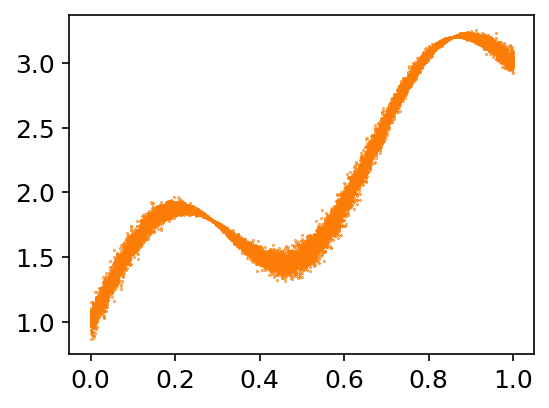

In [20]:
N_SAMPLES = 15000
xdata = np.random.uniform(0,1,N_SAMPLES)

lognormal = False
if lognormal:
    eps = (0.2 * np . random . lognormal ( mean =0.0 , sigma =0.75 , size = N_SAMPLES )
    * 0.4 * np . cos ( xdata * 1.75 * np . pi ))
else:
    eps = (0.2 * np . random . normal ( loc =0.0 , scale =0.75 , size = N_SAMPLES )
    * 0.4 * np . cos ( xdata * 1.75 * np . pi ))    
ydata = 2 * xdata + 1 + eps + 0.5 * np . sin (3 * xdata * np . pi )

plt.figure(figsize=(4,3))
plt.scatter(xdata,ydata,s=0.5,marker='.',color='xkcd:pumpkin orange')
plt.show()

The ydata must be the same shape as the output from the ANN. Since we are predicting three parameters in the SHASH distribution, ydata must have three columns so we append two columns of zeros. 

In [21]:
ydata = np.concatenate((np.expand_dims(ydata,axis=1),np.zeros((N_SAMPLES,2))),axis=1)


## Split into training, validation, testing
Since this is more of a demonstrative notebook, not too worried about auto-correlation here

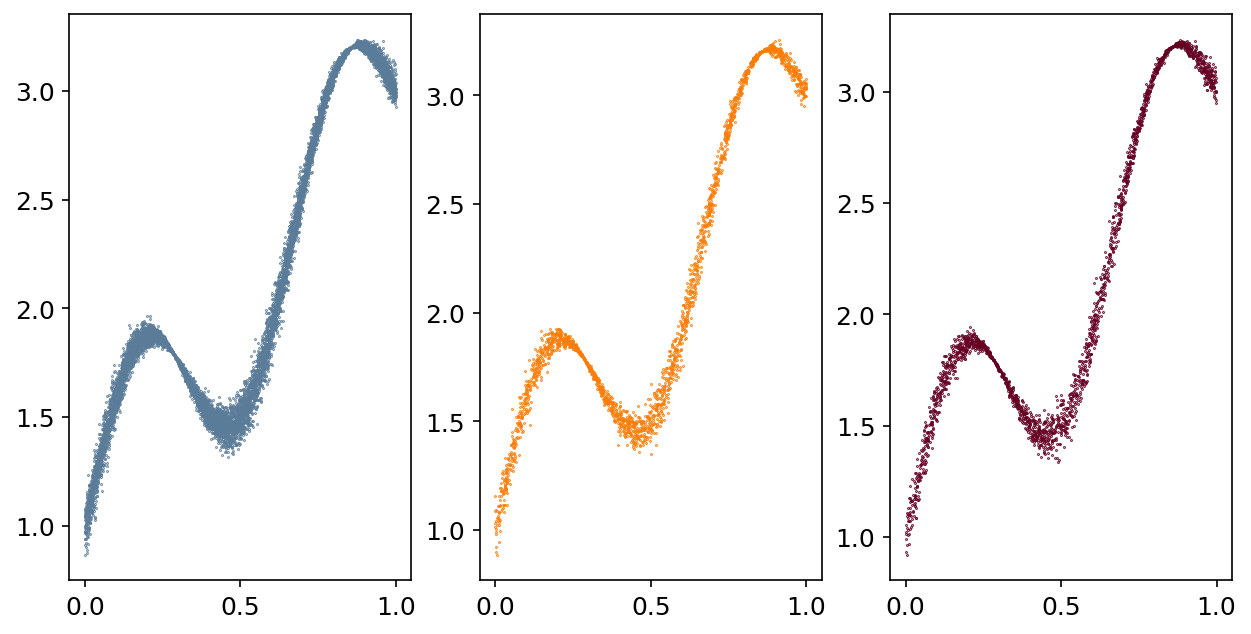

In [22]:
Ntrain = 0.7
Nval = 0.15
Ntest = 0.15

xtrain = xdata[:int(Ntrain*N_SAMPLES)]
xval = xdata[int(Ntrain*N_SAMPLES):int((Ntrain+Nval)*N_SAMPLES)]
xtest = xdata[int((Ntrain+Nval)*N_SAMPLES):]

ytrain = ydata[:int(Ntrain*N_SAMPLES),:]
yval = ydata[int(Ntrain*N_SAMPLES):int((Ntrain+Nval)*N_SAMPLES),:]
ytest = ydata[int((Ntrain+Nval)*N_SAMPLES):,:]

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.scatter(xtrain,ytrain[:,0],s=0.5,color='xkcd:slate blue',marker='.')

plt.subplot(1,3,2)
plt.scatter(xval,yval[:,0],s=0.5,color='xkcd:pumpkin orange',marker='.')

plt.subplot(1,3,3)
plt.scatter(xtest,ytest[:,0],s=0.5,color='xkcd:maroon',marker='.')


## Set the custom loss function 

In [23]:
def RegressLossExpSHASH(y_true, y_pred):
    
    # network prediction of the value
    mu = tf.cast(y_pred[:,0], tf.float64)   
    
    # network prediction of the sigma = exp(unit_2), simple trick prevents model predicting a negative sigma since 
    std = tf.math.exp(tf.cast(y_pred[:,1], tf.float64))   

    skew = tf.cast(y_pred[:,2],tf.float64)
    shash_dist = tfp.distributions.SinhArcsinh(loc=mu,scale=std,skewness=skew,tailweight=1.)

    # compute the log as the -log(p)
    loss = -shash_dist.log_prob(tf.cast(y_true[:,0],tf.float64))
    loss = tf.cast(loss,tf.float64)       

    return tf.reduce_mean(loss, axis=-1)

In [24]:
lr =  0.001 #learning rate
batch_size = 32
n_epochs = 200 #number of training epochs
activation = 'sigmoid' #activation function on hidden layers
hiddens = [100,100] #hidden layers e.g. [5,8] is two hiddens layers the first with 5 nodes and the second with 8 nodes

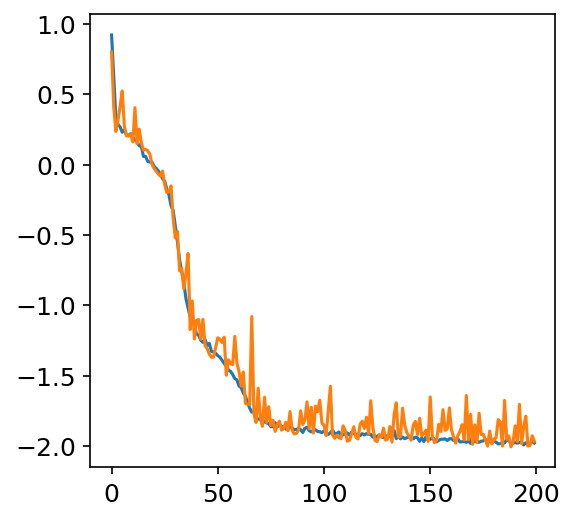

In [25]:
loss = RegressLossExpSHASH #loss function
nhiddens = len(hiddens)

model = tf.keras.models.Sequential()

# First hidden layer
model.add(tf.keras.layers.Dense(hiddens[0], activation=activation, input_shape=(1,),
                bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                ))

# and the rest of the layers
for ilayer in range(1,nhiddens):
    model.add(tf.keras.layers.Dense(hiddens[ilayer], activation=activation,
                    bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                    kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                    )) 

# final layer
model.add(tf.keras.layers.Dense(3,activation='linear',
                bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),))


model.compile(optimizer=tf.keras.optimizers.Adam(lr),  # optimizer
            loss=loss,   # loss function   
             ) 

history = model.fit(xtrain, ytrain, epochs=n_epochs, batch_size=batch_size, validation_data=(xval, yval), 
                shuffle=True, verbose=0)

plt.figure(figsize=(4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

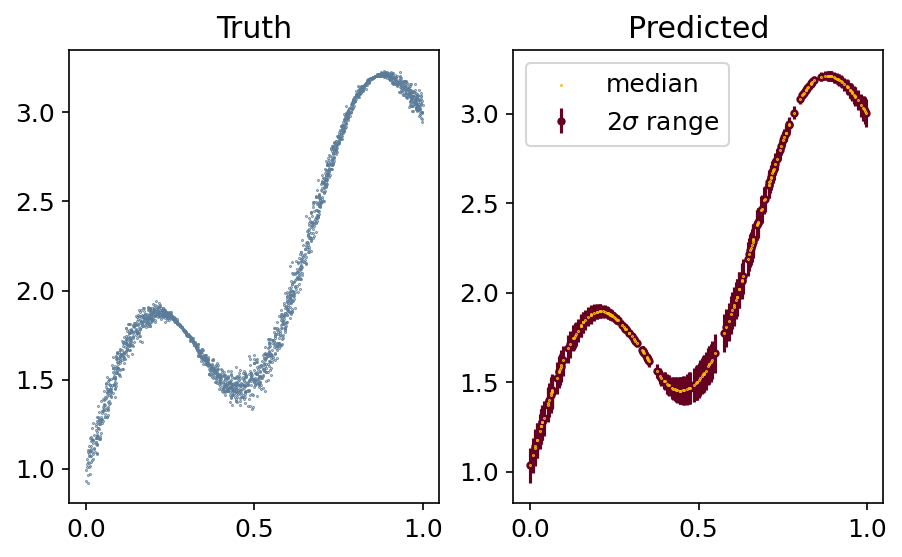

In [26]:
y_pred = model.predict(xtest)

y_mu = y_pred[:,0]
y_sigma = np.exp(y_pred[:,1])
y_gamma = y_pred[:,2]

dists = tfp.distributions.SinhArcsinh(loc=y_mu,scale=y_sigma,skewness=y_gamma,tailweight=1.)
perc_low = dists.quantile(.05).numpy()
perc_high = dists.quantile(.95).numpy()
median_pred = dists.quantile(.5).numpy()  
yerr = np.swapaxes(np.append(perc_low[:,np.newaxis],perc_high[:,np.newaxis],axis=-1),1,0)
errbars = np.abs(median_pred-yerr)

plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
plt.scatter(xtest,ytest[:,0],s=0.5,marker='.',color='xkcd:slate blue')
plt.title('Truth')

plt.subplot(1,2,2)
plt.errorbar(xtest[::10],median_pred[::10],errbars[:,::10],marker='.',color='xkcd:maroon',linestyle='none',zorder=0,label=r'2$\sigma$ range')
plt.scatter(xtest[::10],median_pred[::10],s=0.7,marker='.',color='xkcd:golden rod',zorder=2,label='median')
plt.title("Predicted")
plt.legend()

plt.show()


Check the skewness prediction, if the data is normally distributed, these should all be very close to zero (implying the ANN recognized no skewness required)

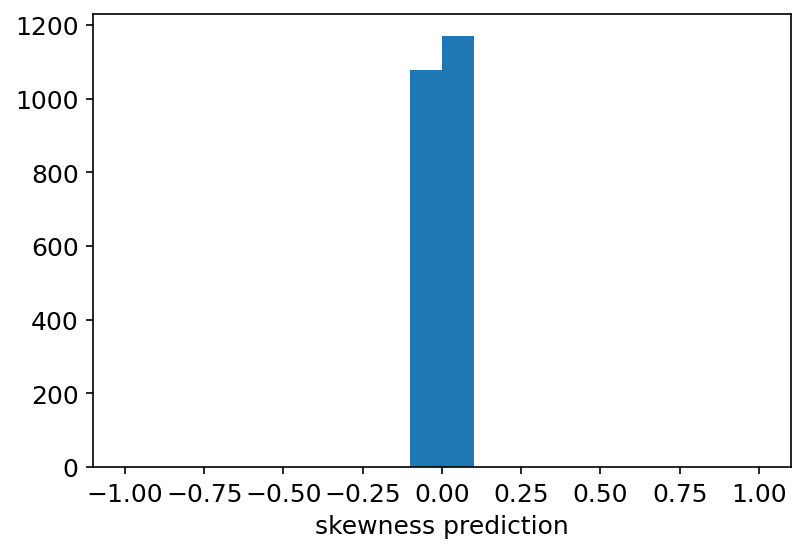

In [27]:
if lognormal:
    plt.hist(y_gamma,bins=np.arange(-2.5,3,0.5))
    plt.xlabel('skewness prediction')
else:
    plt.hist(y_gamma,bins=np.arange(-1,1.1,0.1))
    plt.xlabel('skewness prediction')